## 3.2 Decentralized Gradient Descent (Adapt-then-combine)

### 3.2.1 Problem and distributed gradient descent

Consider $n$ computing nodes collaborate to solve the problem:

$$\min_{x\in \mathbb{R}^d} \quad \frac{1}{n}\sum_{i=1}^n f_i(x)$$

where $f_i(x)$ is a local and private function held by node $i$. Each node $i$ can access its own variable $x$ or gradient $\nabla f_i(x)$, but it has to communicate to access information from other nodes.

If each $f_i(x)$ is assumed to be smooth, the leading algorithm to solve the above problem is gradient descent:

$$\begin{align}
x^{(k+1)} = \frac{1}{n}\sum_{i=1}^n \Big(x^{(k)} - \alpha \nabla f_i(x^{(k)}) \Big) \quad \mbox{(distributed gradient descent)}
\end{align}$$

### 3.2.2 Decentralized gradient descent

In this section we disscuss a new gradient descent that can solve the optimization problem in a decentralized manner. To this end, we first organize all computing nodes with a connected network topology. Next we generate a doubly stochastic combination matrix $W$. For more details on the network topology and combination matrix, please check Sections [2.2](../Sec-2.2-Network-topology.ipynb)-[2.4](../Sec-2.4-Combination-matrix-over-directed-network.ipynb).

With combination matrix $W$, the decentralized gradient descent has recursions as follows:

\begin{align}
y_i^{(k)} &= x_i^{(k)} - \alpha \nabla f_i(x_i^{(k)}) \hspace{5.5cm} \mbox{(local update)} \\
x_i^{(k+1)} &= \sum_{j=1}^n w_{ij} y_j^{(k)} = w_{ii} y_i^{(k)} + \sum_{j\in\mathcal{N}(i)}w_{ij} y_j^{(k)} \hspace{2.1cm} \mbox{(combination)}
\end{align}

where $\mathcal{N}(i)$ is the set of incoming neighbors of node $i$. It is observed that the combination step incurs partial averaging within neighborhood, which is different from the global averaging used in distributed gradient descent. The partical averaging typically triggers $O(1)$ bandwidth cost and $O(1)$ latency, which is independent of the number of all computing nodes $n$. On a sparse network such as the ring, or the one-peer exponential-two graph \[Refs\], decentralized gradient descent can save significant communications than distributed gradient descdent.

Decentralized gradient descent has two major variants. One variant is as the above recursions. Since the recursion has the "adapt-then-combine" order, we will refer to it as the ATC-DGD \[Refs\]. The other variant will mix the adaptation (i.e., the gradient descent) and combination in the same update, which will be referred to as "adapt-with-combination (AWC)" decentralized gradient descent. There are subtle differences between these two variants. We will leave the discussion of AWC-DGD algorithm in the next section.

### 3.2.3 Convergence properties

We give a brief descrption on the convergence property of the ATC-DGD algorithm. For $L$-smooth and $\mu$-strongly convex problems, if the step-size $\alpha$ is sufficiently small, the ATC-DGD algorithm will converge as follows.

\begin{align}
\limsup_{k\to \infty} \frac{1}{n}\sum_{i=1}^n \|x_i^{(k)} - x^\star \|^2 = O\Big( (1-\alpha \mu)^{k} + \frac{\gamma^2 \rho^2 b^2}{(1-\rho)^2}\Big) \hspace{1cm} \mbox{(DGD-Convergence)}
\end{align}

where $x^\star$ is the glboal solution to the optimization problem, $\rho = \max\{|\lambda_2(W), \lambda_n(W)|\}$ and $b^2 = \frac{1}{n}\sum_{i=1}^n \|\nabla f_i(x^\star)\|^2$ denotes the data heterogeneity between nodes. Quantity $1-\rho$ measures the connectivity of the network topology. It is observed that ATC-DGD cannot converge exactly to the solution $x^\star$, but to a neighborhood around it. The limiting error is on the order of $O(\frac{\alpha^2 b^2}{(1-\rho)^2})$. When step-size $\alpha$ is small, or the data heterogeneity $b^2$ is small, or the network is well-connected, i.e., $\rho \to 0$, the limiting error can be negligible. 

### 3.2.4 An example: least-square problem

In this section, we will show a demo on how to solve a least-square problem with ATC-DGD using BlueFog. Suppose $n$ computing nodes collaborate to solve the following problem:

$$\min_x \quad \frac{1}{n}\sum_{i=1}^n \|A_i x - b_i\|^2$$

where $\{A_i, b_i\}$ are local data held in node $i$.

#### 3.2.4.1 Set up BlueFog

In the following code, you should be able to see the id of your CPUs. We use 8 CPUs to conduct the following experiment.

In [47]:
import ipyparallel as ipp

rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

Let each agent import necessary modules and then initialize BlueFog. You should be able to see the printed information like:  

> \[stdout:0\] Hello, I am 1 among 8 processes
> 
> ...

In [48]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 2 among 8 processes
[stdout:1] Hello, I am 4 among 8 processes
[stdout:2] Hello, I am 7 among 8 processes
[stdout:3] Hello, I am 6 among 8 processes
[stdout:4] Hello, I am 3 among 8 processes
[stdout:5] Hello, I am 0 among 8 processes
[stdout:6] Hello, I am 5 among 8 processes
[stdout:7] Hello, I am 1 among 8 processes


Push seed to each agent so that the simulation can be reproduced.

In [49]:
dview = rc[:] # A DirectView of all engines
dview.block=True

# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None, None, None, None, None]

After running the following code, you should be able to see the printed information like 

> \[stdout:0\] I received seed as value:  2021
> 
> ...

In [50]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021
[stdout:4] I received seed as value:  2021
[stdout:5] I received seed as value:  2021
[stdout:6] I received seed as value:  2021
[stdout:7] I received seed as value:  2021


Congratulations! Your BlueFog is initialized and tested successfully.

#### 3.2.4.2 Generate local data $A_i$ and $b_i$

In [51]:
%%px

def generate_data(m, n):
    
    A = torch.randn(m, n).to(torch.double)
    x_o = torch.randn(n, 1).to(torch.double)
    ns = 0.1*torch.randn(m, 1).to(torch.double)
    b = A.mm(x_o) + ns
        
    return A, b

#### 3.2.4.3 Distributed gradient descent method

In [52]:
%%px

def distributed_grad_descent(A, b, maxite=5000, alpha=1e-1):

    x_opt = torch.zeros(n, 1, dtype=torch.double)

    for _ in range(maxite):
        # calculate local gradient 
        grad_local = A.t().mm(A.mm(x_opt) - b)
        
        # global gradient
        grad = bf.allreduce(grad_local, name='gradient')

        # distributed gradient descent
        x_opt = x_opt - alpha*grad

    grad_local = A.t().mm(A.mm(x_opt) - b)
    grad = bf.allreduce(grad_local, name='gradient')  # global gradient

    # evaluate the convergence of distributed gradient descent
    # the norm of global gradient is expected to 0 (optimality condition)
    global_grad_norm = torch.norm(grad, p=2)
    if bf.rank() == 0:
        print("[Distributed Grad Descent] Rank {}: global gradient norm: {}".format(bf.rank(), global_grad_norm))

    return x_opt

In the following code we run distributed gradient descent to achieve the global solution $x^\star$ to the optimization problem. To validate whether $x^\star$ is optimal, it is enough to examine $\frac{1}{n}\sum_{i=1}^n \nabla f_i(x^\star) = 0$.

In [53]:
%%px

m, n = 20, 5
A, b = generate_data(m, n)
x_opt = distributed_grad_descent(A, b, maxite=200, alpha=1e-2)

[stdout:5] [Distributed Grad Descent] Rank 0: global gradient norm: 7.236065407667669e-15


#### 3.2.4.3 Decentralized gradient descent method

In this section, we depict the convergence curve of the decentralied gradient descent (the ATC version). We will utilize the $x^\star$ achieved by distributed gradient descent as the optimal solution. First, we define one step of the ATC-DGD method.

In [54]:
%%px 

def ATC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):
    
    # one-step ATC-DGD. 
    # The combination weights have been determined by the associated combination matrix.
    
    grad_local = A.t().mm(A.mm(x) - b)      # compute local grad
    y = x - alpha*grad_local                # adapte
    x_new = bf.neighbor_allreduce(y)        # combination
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_opt, p=2)/torch.norm(x_opt,p=2)

    return x_new, rel_error

Next we run ATC-DGD algorithm.

In [75]:
%%px

# Set topology as exponential-two topology.
G = topology_util.ExponentialTwoGraph(bf.size())
bf.set_topology(G)

maxite = 200
x = torch.zeros(n, 1, dtype=torch.double)     # Initialize x
rel_error = torch.zeros((maxite, 1))
for ite in range(maxite):
    
    if bf.rank()==0:
        if ite%10 == 0:
            print('Progress {}/{}'.format(ite, maxite))
        
    x, rel_error[ite] = ATC_DGD_one_step(x, x_opt, A, b, alpha=3e-3) # you can adjust alpha to different values

[stdout:5] 
Progress 0/200
Progress 10/200
Progress 20/200
Progress 30/200
Progress 40/200
Progress 50/200
Progress 60/200
Progress 70/200
Progress 80/200
Progress 90/200
Progress 100/200
Progress 110/200
Progress 120/200
Progress 130/200
Progress 140/200
Progress 150/200
Progress 160/200
Progress 170/200
Progress 180/200
Progress 190/200


In the following, we adjust step-size to differnt values to examine its influence on the convergence rate and limiting bias.

In [66]:
# collect relative error from node 0 for step-size 1e-2
rel_error_exp2_alpha1em2 = dview.pull('rel_error', block=True, targets=0)

In [68]:
# collect relative error from node 0 for step-size 5e-3
rel_error_exp2_alpha5em3 = dview.pull('rel_error', block=True, targets=0)

In [76]:
# collect relative error from node 0 for step-size 3e-3
rel_error_exp2_alpha3em3 = dview.pull('rel_error', block=True, targets=0)

Text(0, 0.5, 'Relative error')

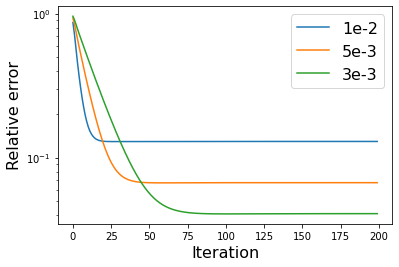

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogy(rel_error_exp2_alpha1em2)
plt.semilogy(rel_error_exp2_alpha5em3)
plt.semilogy(rel_error_exp2_alpha3em3)

plt.legend(['1e-2', '5e-3', '3e-3'], fontsize=16)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

It is observed from the above figures that smaller alpha can lead to more accuate solution, but the convergence rate will get slower. This observation is consistent with Eq. (DGD-Convergence).